(lecture16:diagnostics-for-classification)=
# Diagnostics for Classification

Let's repeat what we did for the HMX example, but after splitting the dataset into training and test subsets.
We will be making predictions on the validation subset.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'svg')
import numpy as np
import scipy.stats as st
import pandas as pd
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

In [3]:
# Download the data file:
url = 'https://raw.githubusercontent.com/PurdueMechanicalEngineering/me-297-intro-to-data-science/master/data/hmx_data.csv'
download(url)
# Load the data using pandas
import pandas as pd
data = pd.read_csv('hmx_data.csv')
# Extract data for regression
# Heights as a numpy array
x = data['Height'].values
# The labels must be 0 and 1
# We will use a dictionary to indicate our labeling
label_coding = {'E': 1, 'N': 0}
y = np.array([label_coding[r] for r in data['Result']])
data['y'] = y
data.head()

,Height,Result,y
0,40.5,E,1
1,40.5,E,1
2,40.5,E,1
3,40.5,E,1
4,40.5,E,1


Separate data into training and test subsets:

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y)

Let me visualize these as well:

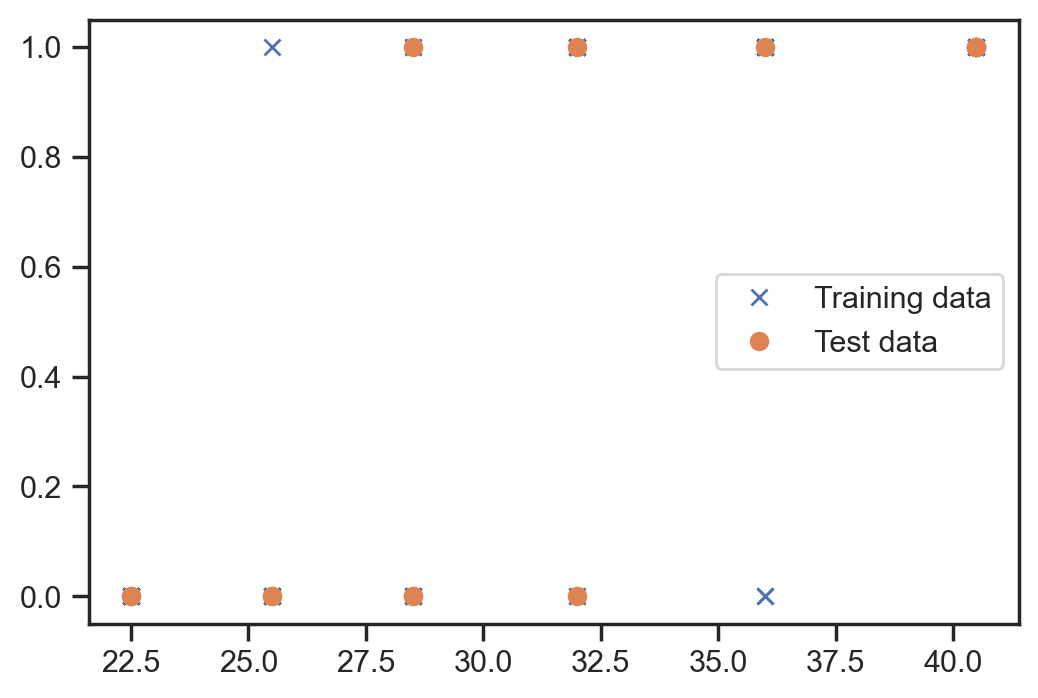

In [7]:
fig, ax = plt.subplots()
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_test, y_test, 'o', label='Test data')
plt.legend(loc='best');

Let's do the logistic regression as before:

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
# Make the design matrix
poly = PolynomialFeatures(2)
Phi_train = poly.fit_transform(x_train[:, None])
model = LogisticRegression(penalty='none', fit_intercept=False).fit(Phi_train, y_train)

Okay, the model is trained.
Let's now make predictions on the test set:

In [10]:
Phi_test = poly.fit_transform(x_test[:, None])
predictions = model.predict_proba(Phi_test)

Notice that our predictions are probabilistic.
Specifically, `predictions` has two columns.
The first column is the probability that $y=0$ (no explosion) and the second column is the probability that $y=1$ (explosion).
Here it is:

In [11]:
predictions

array([[0.00949576, 0.99050424],
       [0.00949576, 0.99050424],
       [0.732914  , 0.267086  ],
       [0.43319292, 0.56680708],
       [0.92335417, 0.07664583],
       [0.00949576, 0.99050424],
       [0.92335417, 0.07664583],
       [0.00949576, 0.99050424],
       [0.10866218, 0.89133782],
       [0.43319292, 0.56680708],
       [0.86547853, 0.13452147],
       [0.00949576, 0.99050424],
       [0.732914  , 0.267086  ],
       [0.86547853, 0.13452147],
       [0.732914  , 0.267086  ]])

One of the easiest visualizations you can do is the following.
In the same plot, show put a point either at 0 or 1 depending on what the actual prediction is and then draw a bar for the probability that $y=1$.
Here it is:

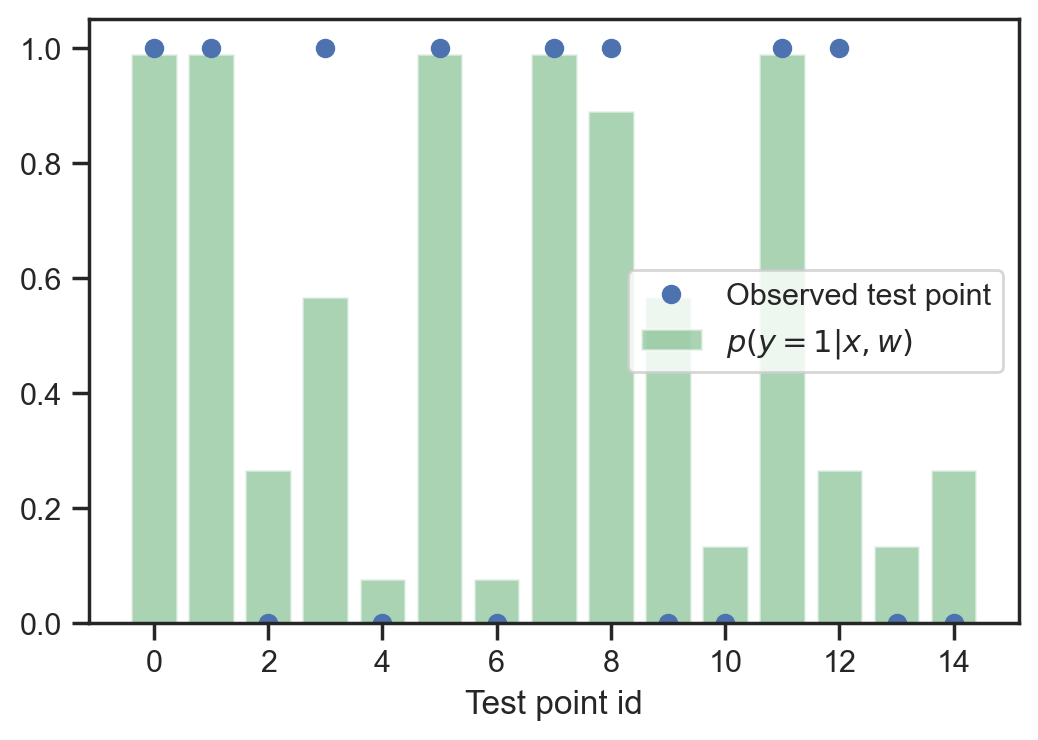

In [21]:
fig, ax = plt.subplots()
ax.bar(np.arange(y_test.shape[0]), predictions[:, 1], color='g', alpha=0.5, label='$p(y=1|x,w)$')
ax.plot(y_test, 'o', label='Observed test point')
ax.set_xlabel('Test point id')
plt.legend(loc='best');

So, in this plot, the closer the bar is to the observation, the better the prediction.

Now, sometimes you may want to make pointwise predictions.
That is, you look at the probability reported by the model and you have to pick either 0 or 1.
There is a whole theory of how to do this properly: the theory of decision-making.
If you want to learn more about it, you can take a course like [ME 597 "Decision-making in Engineering Systems"](https://engineering.purdue.edu/DELP/decision_course).
Here, we are going to do something very simple.
We will just pick the label that has the maximum probability.
Here is how:

In [24]:
y_pred = np.argmax(predictions, axis=1)
print(y_pred)

[1 1 0 1 0 1 0 1 1 1 0 1 0 0 0]


Let's repeat the figure above but now add this point prediction as a red cross.

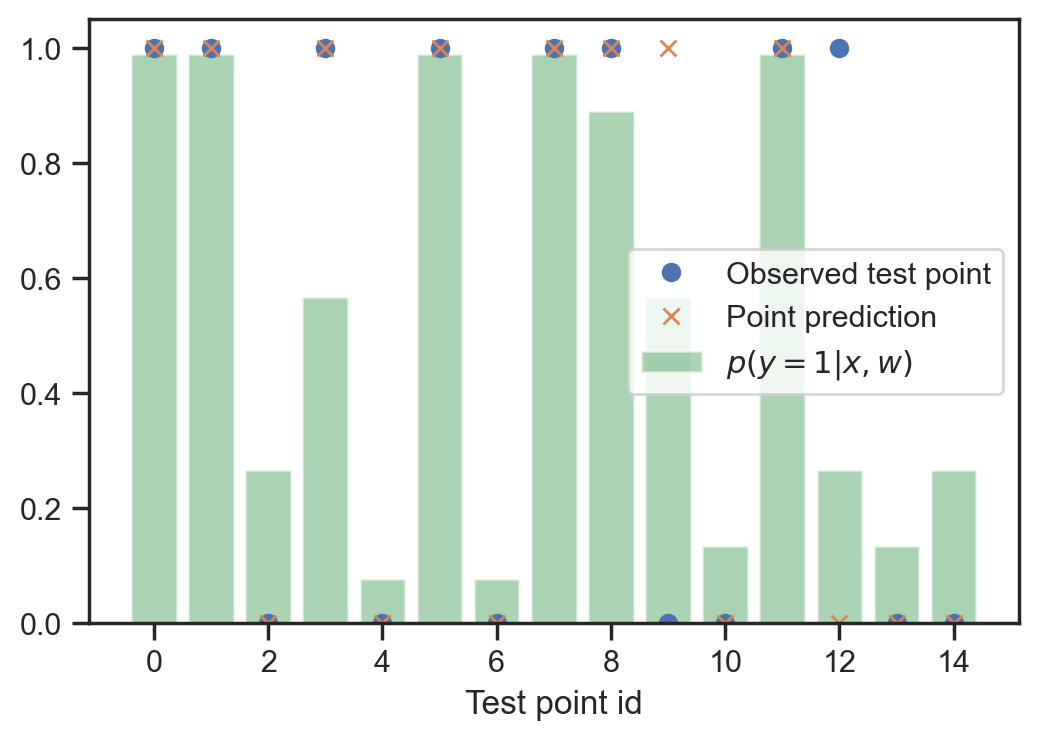

In [25]:
fig, ax = plt.subplots()
ax.bar(np.arange(y_test.shape[0]), predictions[:, 1], color='g', alpha=0.5, label='$p(y=1|x,w)$')
ax.plot(y_test, 'o', label='Observed test point')
ax.plot(y_pred, 'x', label='Point prediction')
ax.set_xlabel('Test point id')
plt.legend(loc='best');

Nice. So, the model is pretty good. Most of the times we make the correct prediction.
You can summarize how good the predictions are using the accuracy score.
The accuracy score is:

$$
\text{accuracy score} = \frac{\text{number of correct predictions}}{\text{total number of test samples}}.
$$

Here is how we can calculate it:

In [27]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print('HMX Accuracy = {0:1.2f} %'.format(acc * 100))

HMX Accuracy = 86.67 %


Not bad. 

```{note}
The accuracy score can be very misleading.
The problem is how well-balanced your dataset is.
As an extreme example, imagine that we had an dataset in which explosions are very rare, say only 1%.
Then a stupid model that predicts that there will never be an explosion would have 99% accuracy.
This is clearly ridiculous...
The situation is remedied by the concept of [balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score).
```

Finally, a nice way to visualize the predictions of your model is to use the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
It is self-evident what it is when I plot it for you.
Here you go:

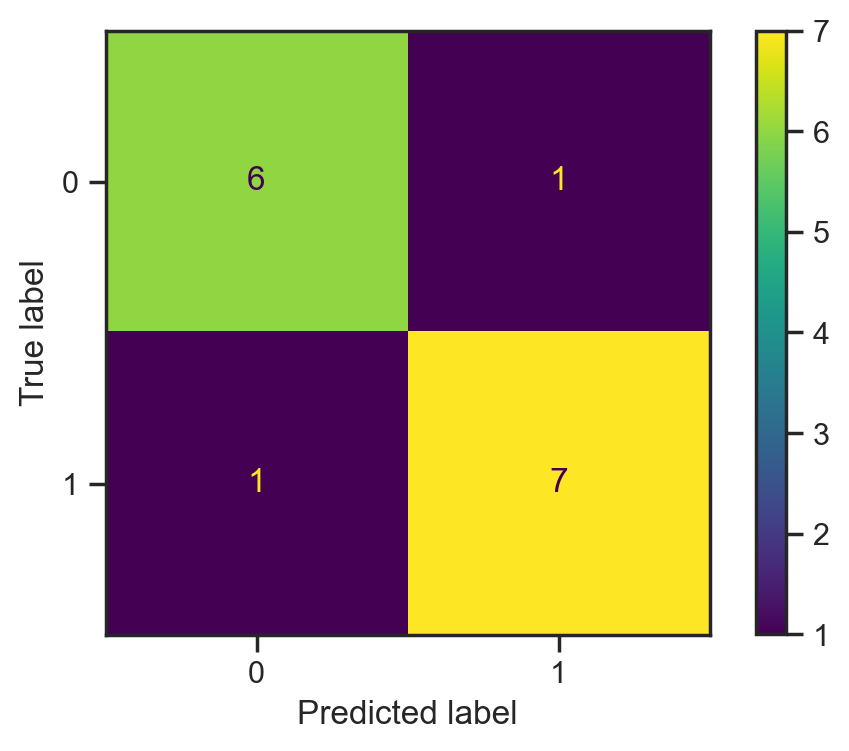

In [31]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
fig, ax = plt.subplots()
plot_confusion_matrix(model, Phi_test, y_test, ax=ax);

## Questions

+ Repeat the analysis above with a higher degree polynomial, say 5. Is the result better or worse? Why?